In [ ]:
from wavelet_transformation import cwt_transform, plot_cwt
from sample_function import DoubleGaussianWell, Gausslet
import numpy as np
import matplotlib.pyplot as plt


V = DoubleGaussianWell((0.0, 10.0), c1=2.8, fwhm1=0.5, depth1=9.0,
                                   c2=7.2, fwhm2=1.2, depth2=4.5)
x_min, x_max = V.domain
b = np.linspace(x_min, x_max, 300)            # positions
a = np.geomspace(0.1, 1.5, 256)               # scales

_, coe = np.loadtxt("coefficient/G4.csv", delimiter=",", unpack=True)
gausslet = Gausslet(coe, 0.1)

W = cwt_transform(V, gausslet, x_min, x_max, a, b, n_samples=4096, chunk_size=512)
plot_cwt(W, a, b, title="CWT |W| of DoubleGaussianWell")


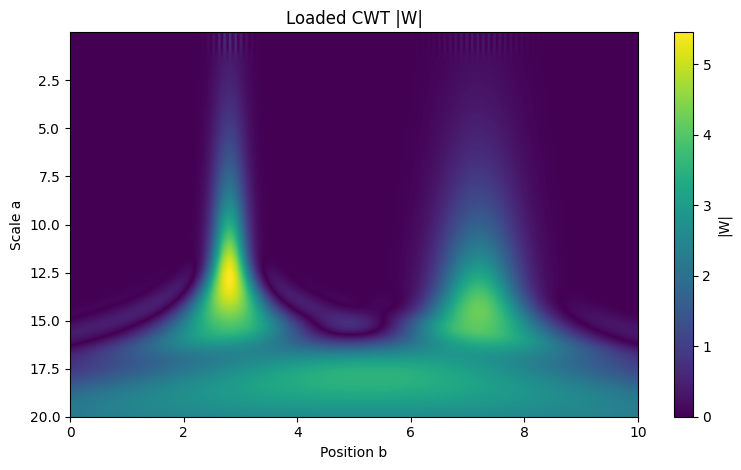

In [14]:
from wavelet_transformation import cwt_transform_parallel, plot_cwt, save_cwt, load_cwt, mexican_hat
from sample_function import DoubleGaussianWell, Gausslet, SineBackgroundWithGaussians
import numpy as np
import matplotlib.pyplot as plt


def lift_wavelet_1d_to_2d(psi_1d):
    """
    把仅支持 1D 的 ψ(u) 提升为可处理任意形状 U 的 ψ(U)，逐行/逐块映射后再 reshape 回去。
    - 输入 U 可以是标量、1D、2D、甚至更高维（都会被展平→逐元素应用→再 reshape）
    - 适用于 Gausslet 这类只实现了 1D evaluate 的小波
    """
    def psi_U(U: np.ndarray) -> np.ndarray:
        U = np.asarray(U)
        flat = U.reshape(-1)
        vals = psi_1d(flat)                 # 调用原本的 1D 接口
        vals = np.asarray(vals)
        return vals.reshape(U.shape)
    return psi_U

V = DoubleGaussianWell((0.0, 10.0), c1=2.8, fwhm1=0.5, depth1=9.0,
                                   c2=7.2, fwhm2=1.2, depth2=4.5)
#V = SineBackgroundWithGaussians()
x_min, x_max = V.domain
b = np.linspace(x_min, x_max, 500)            # positions
a = np.geomspace(0.001, 20, 512)               # scales

_, coe = np.loadtxt("coefficient/G4.csv", delimiter=",", unpack=True)
gausslet = Gausslet(coe, 1)



W = cwt_transform_parallel(V, lift_wavelet_1d_to_2d(gausslet), x_min, x_max, a, b,
                           n_samples=4096, chunk_size=64, n_workers=8)


save_cwt("data/cwt_V.npz", W, a, b, meta={"domain": (x_min, x_max), "n_samples": 4096,
                                     "wavelet_tag": "gausslet_g4_s=0.1_c=0"})

loaded = load_cwt("data/cwt_V.npz")
W2 = loaded["W"]; a2 = loaded["scales"]; b2 = loaded["positions"]
plot_cwt(W2, a2, b2, title="Loaded CWT |W|")